In [174]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import healpy as hp
from src.build_yx1.make_field_plots_v2 import plot_healpix_equalarea_from_frame
import zarr

In [247]:
root = "/media/nick/cluster/projects/data/killi_tracker/"
project_name = "20250716"
projection_path = Path(root) / "output_data" / "sphere_projections" / project_name
well_list = sorted(projection_path.glob("*0128.zarr"))
well_ind = 0
well_zarr_path = projection_path / f"well{well_ind:04}_fields_0128.zarr"
values_key="mean"
t_index = 32
channel_index = 0
field_zarr = zarr.open(well_zarr_path, mode="r")

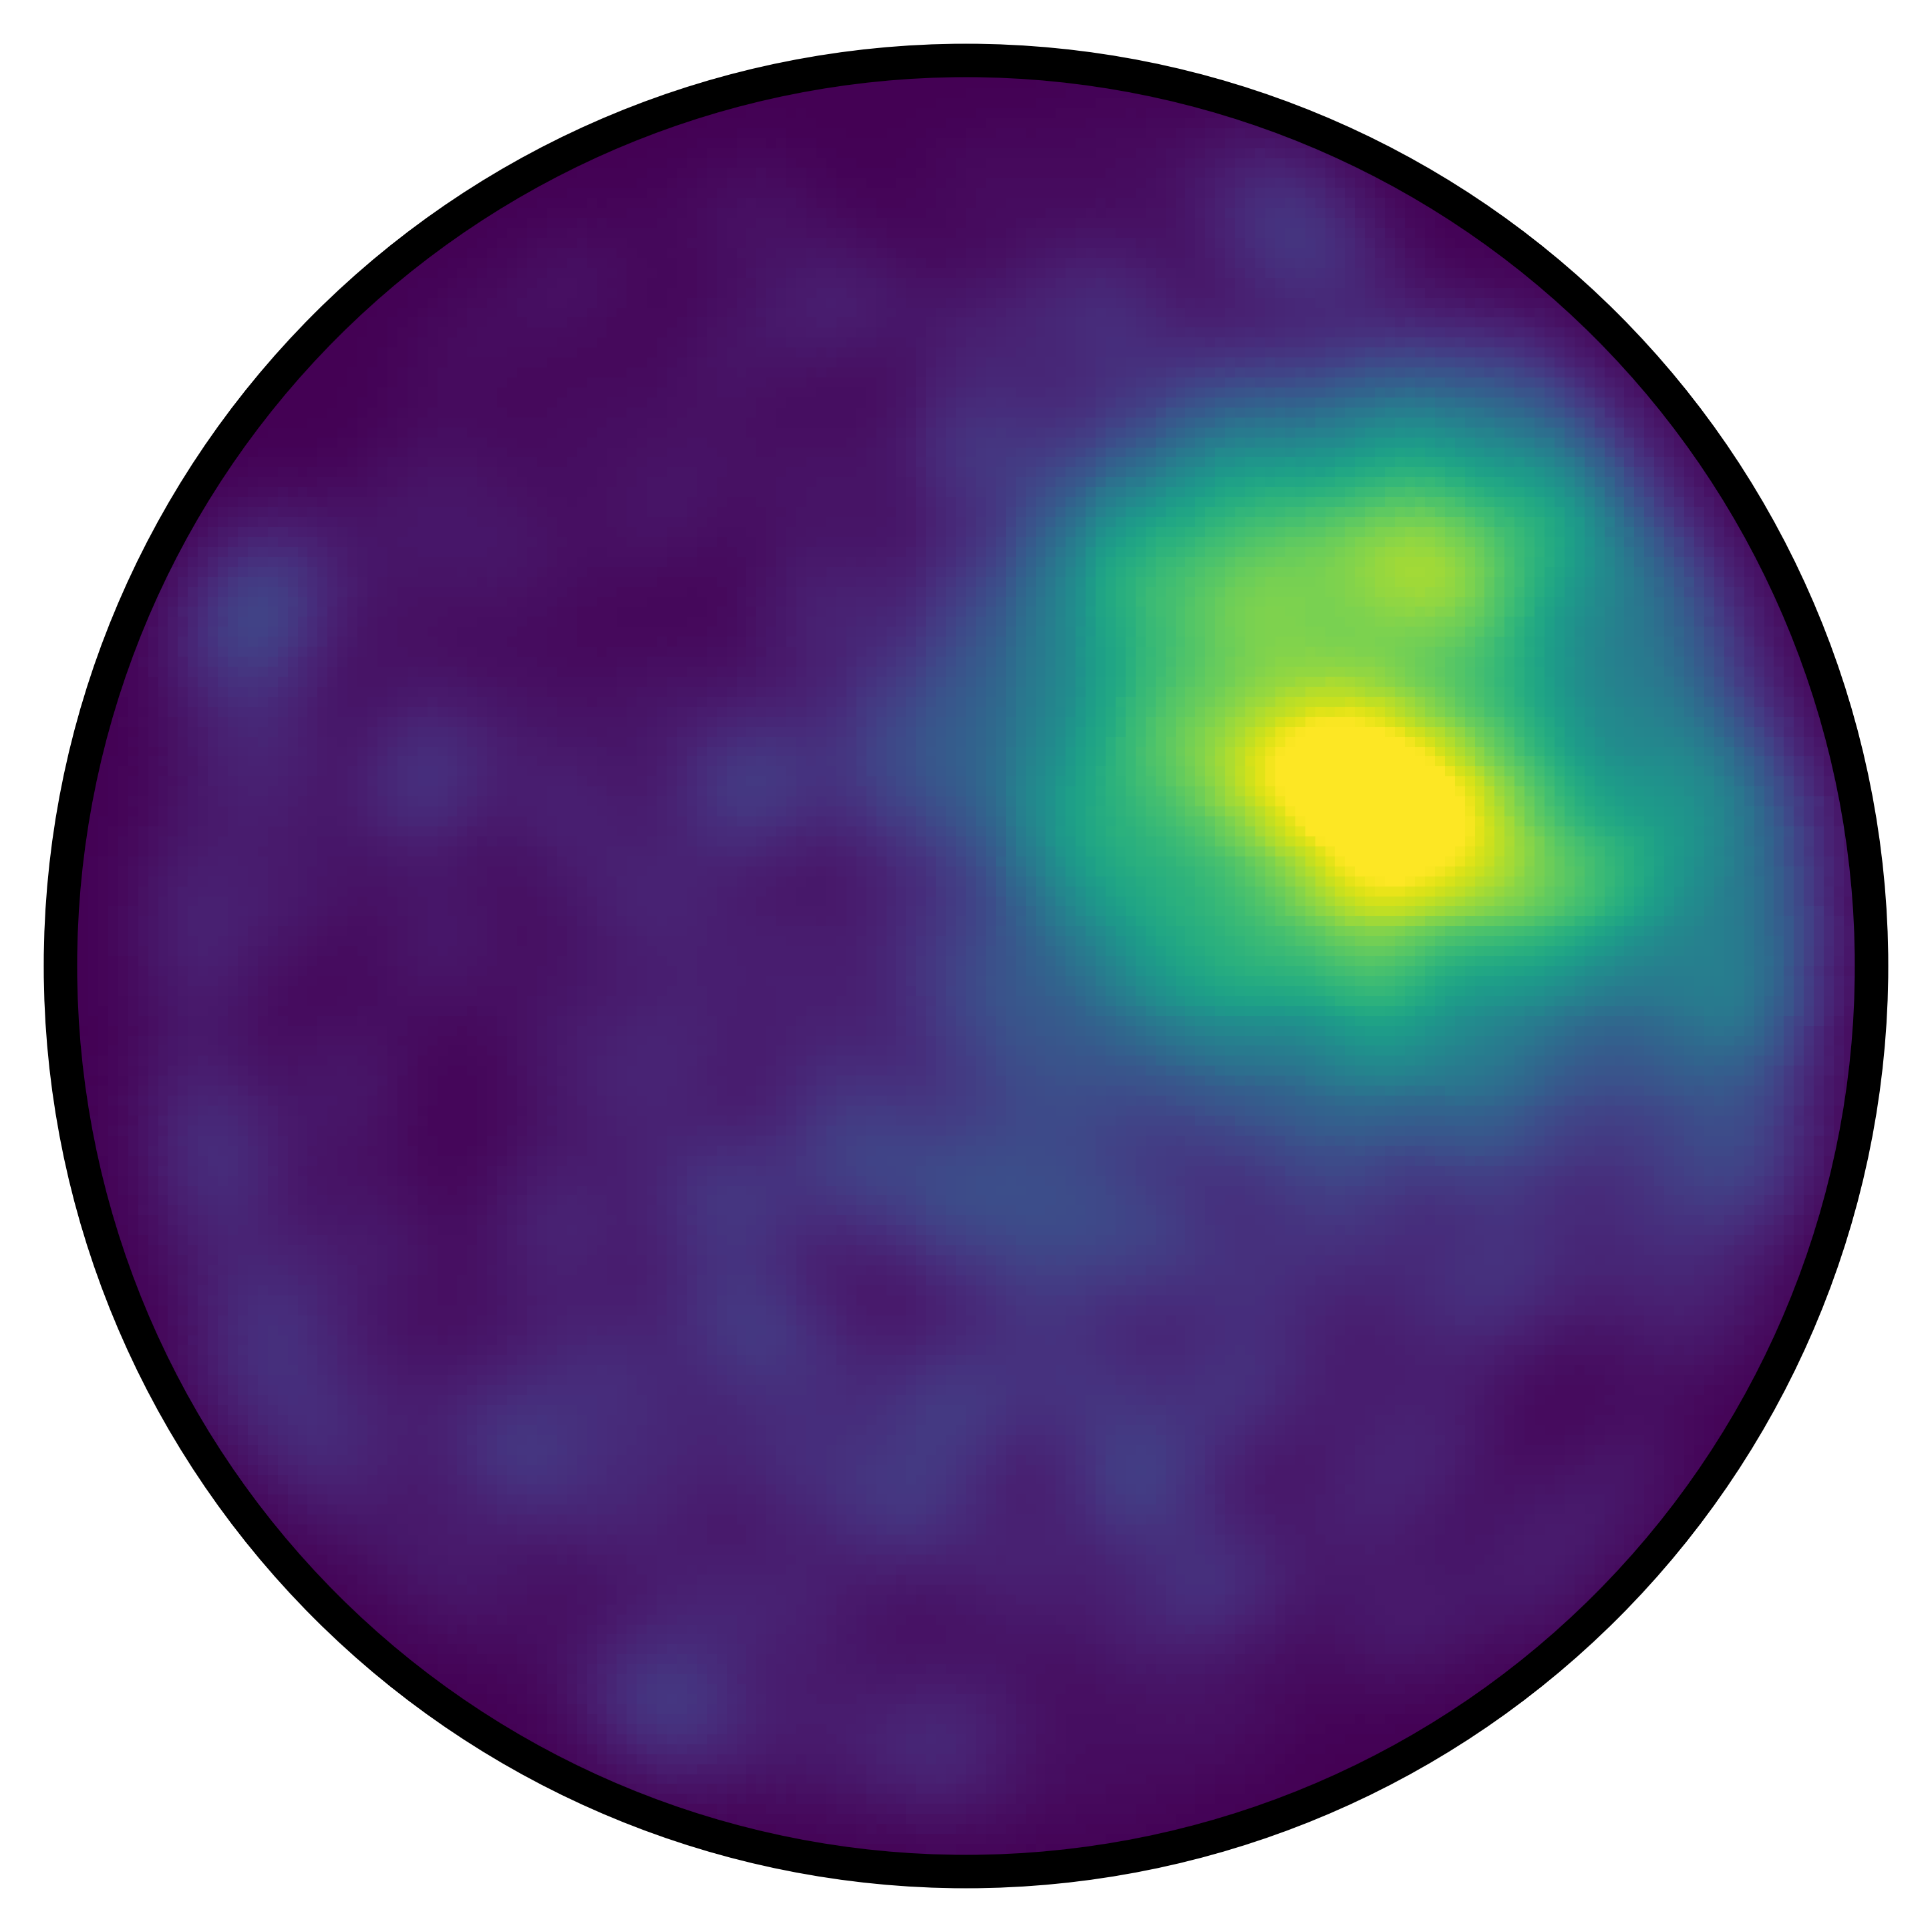

In [248]:
frame_1d = field_zarr["density"]
img = plot_healpix_equalarea_from_frame(frame_1d[t_index], show=True, fov_deg=60, rescale_to_fill=True, smooth_fwhm_deg=8)

## Quantify degree of anisotropy over time

In [250]:
bc1_arr = field_zarr["density"]
ch = 0
sm_deg = 0.05
anisotropy_vec = np.zeros((bc1_arr.shape[0], ))
null_vec = np.zeros((bc1_arr.shape[0], ))
n_cells_vec =  np.zeros((bc1_arr.shape[0], ))
nside = 128

# compute mask
f0_raw = bc1_arr[0]
f0 = hp.smoothing(f0_raw, fwhm=np.deg2rad(1))
mask = f0 > 0.0001

npix  = hp.nside2npix(nside)
x, y, z = hp.pix2vec(nside, np.arange(npix), nest=False)  # or True, if NESTED
n_vecs = np.vstack([x, y, z]).T

for t in range(bc1_arr.shape[0]):
    f0_raw = bc1_arr[t]#, ch]
    f0_null = f0_raw.copy()
    
    f0 = hp.smoothing(f0_raw, fwhm=np.deg2rad(sm_deg))
    f0_masked = f0[mask]
    n = n_vecs[mask]
    # S: (npix,) field on hemisphere mask M (bool), n_vecs: (npix, 3) unit vectors
    # S_masked = S[M]
    # n = n_vecs[M]
    w = np.ones_like(f0_masked)  # equal-area HEALPix; replace if needed

    f0_null[mask] = np.random.choice(f0_raw[mask], len(f0_masked), replace=False)
    f0_null = hp.smoothing(f0_null, fwhm=np.deg2rad(sm_deg))
    f0_null = f0_null[mask]
    
    # caclulate for true
    mu = np.mean(f0_masked)
    d = f0_masked - mu
    
    v = (w[:, None] * d[:, None] * n).sum(axis=0)
    A1 = np.linalg.norm(v)# / (np.abs(d) * w).sum()
    # dir_v = v / (np.linalg.norm(v) + 1e-12)
    anisotropy_vec[t] = A1

    # calculate for null
    mu = np.mean(f0_null)
    d = f0_null - mu
    
    v = (w[:, None] * d[:, None] * n).sum(axis=0)
    A1 = np.linalg.norm(v) #/ (np.abs(d) * w).sum()
    # dir_v = v / (np.linalg.norm(v) + 1e-12)
    null_vec[t] = A1

    n_cells_vec[t] = np.sum(f0_masked)

anisotropy_vec[t]

434.7442439094069

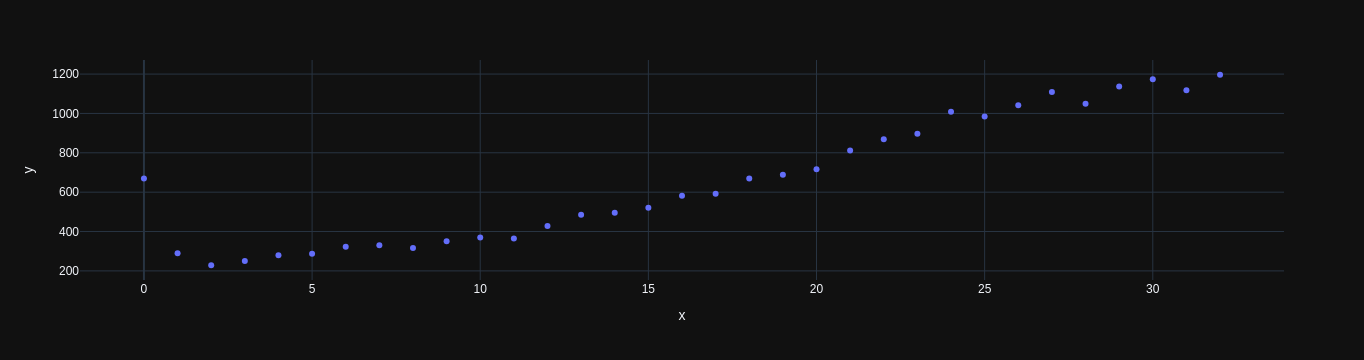

In [251]:
fig = px.scatter(x=np.arange(len(anisotropy_vec)), y=n_cells_vec)
fig.show()

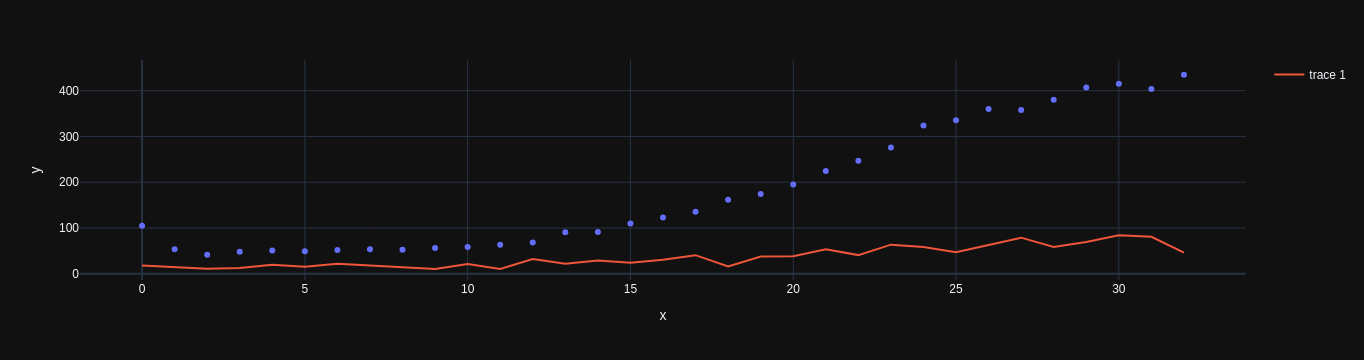

In [252]:
fig = px.scatter(x=np.arange(len(anisotropy_vec)), y=anisotropy_vec)
fig.add_traces(go.Scatter(x=np.arange(len(anisotropy_vec)), y=null_vec))
fig.show()


### Use NN stats to estimate each cell's local density

In [ ]:
from src.symmetry_breaking.cluster_tracking import find_clusters_per_timepoint, track_clusters_over_time, stitch_tracklets
from tqdm import tqdm 

# 1) clusters per frame
clusters_by_t = find_clusters_per_timepoint(
    deep_track_df, 
    sphere_df,
    d_thresh=40.0, 
    min_size=25,  # tune
    fluo_col="mean_fluo",
    sphere_center_cols=("xs", "ys","zs")
)

# 2) link across time (motion/feature-aware, with merges)
cluster_ts, merges_df = track_clusters_over_time(
    clusters_by_t,
    link_metric="overlap",         # or "jaccard"
    sim_min=0.3,
    max_centroid_angle=np.deg2rad(15),
    w_sim=1.0, w_feat=0.7, w_pred=0.7,  # tune
    pred_step=1.0
)

# 3) stitch fragmented tracklets (bridge small gaps, fix flips)
stitched_ts, stitch_log = stitch_tracklets(
    cluster_ts,
    gap_max=2, window=1,
    link_metric="overlap", sim_min=0.3,
    max_centroid_angle=np.deg2rad(15),
    w_sim=1.0, w_feat=0.7, w_pred=0.7, w_size=3.0,
    max_iters=3
)

In [ ]:
# cluster_ts.tail()

In [ ]:
from src.utilities.plot_functions import format_2d_plotly

cluster_ts["cluster_id"] = cluster_ts["cluster_id"].astype(int) 
fig = px.scatter(cluster_ts, x="fluo_mean", y="deg_mean", size="size", color="t")
fig = format_2d_plotly(fig,axis_labels=["nuclear BC1", "average degree"], marker_size=30)
fig.update_traces(marker=dict(size=cluster_ts["size"]))
fig.update_xaxes(range=[100, 700])
fig.update_yaxes(range=[0.9, 6])
fig.show()

In [ ]:
stitched_ts["cluster_id_stitched"] = stitched_ts["cluster_id_stitched"].astype(str) 
fig = px.scatter(stitched_ts, x="t", y="fluo_mean", size="size", color="cluster_id_stitched")
# fig = format_2d_plotly(fig,axis_labels=["time", "average degree"], marker_size=30)
# fig.update_traces(marker=dict(size=cluster_ts["size"]))
fig.update_xaxes(range=[0, 614])
# fig.update_yaxes(range=[0, 6])
fig.show()

In [ ]:
stitched_ts.columns

In [ ]:
lag_vec = results[0]["lags"]
nboots = 100

xcorr_list = []
xcorr_se_list = []
for t in tqdm(range(len(t_bins)-1)):
    results = result_dict[t]
    xcorr_array = np.asarray([r["xcorr"] for r in results])
    options = np.arange(xcorr_array.shape[0])
    mu_array = np.empty((nboots, xcorr_array.shape[1]))
    for n in range(nboots):
        boot_ids = np.random.choice(options, len(options), replace=True)
        mu_array[n, :] = np.mean(xcorr_array[boot_ids, :], axis=0)
    xcorr_mean = np.mean(mu_array, axis=0)
    xcorr_se = np.std(mu_array, axis=0)
    xcorr_list.append(xcorr_mean)
    xcorr_se_list.append(xcorr_se)

In [ ]:
lag_long = np.tile(lag_vec, len(t_bins)-1)
id_vec = np.repeat(np.arange(len(t_bins)-1), len(xcorr_list[0]))
xcorr_long = np.concatenate(xcorr_list, axis=0)
xcorr_se_long = np.concatenate(xcorr_se_list, axis=0)

x_df = pd.DataFrame(id_vec, columns=["time_group"])
x_df["lag"] = lag_long
x_df["corr"] = xcorr_long
x_df["corr_se"] = xcorr_se_long

In [ ]:
fig = px.line(x_df, x="lag", y="corr", error_y="corr_se",color="time_group")
fig.show()

In [ ]:
xcorr_array.shape

In [ ]:
import plotly.graph_objects as go

t = 100
test_df = deep_track_df.loc[deep_track_df["t"]==t, :]
sp_test = sphere_df.loc[sphere_df["t"]==t, :]
fig = go.Figure()
fig.add_traces(go.Scatter3d(x=test_df["x"], y=test_df["y"], z=test_df["z"], mode="markers", marker=dict(opacity=0.1, size=6)))
fig.add_traces(go.Scatter3d(x=sp_test["xs"], y=sp_test["ys"], z=sp_test["zs"], mode="markers", marker=dict(size=6)))
fig.show()

In [ ]:
test_df.shape

In [ ]:
A = 4*np.pi*501**2

### 

In [ ]:
941/A * 1000 * 1000